## IMPORTING PACKAGES

In [1]:
#Imports
#Packages for numerics + dataframes
import numpy as np
import pandas as pd

#Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Packages for machine learning models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

## EXPLORATORY DATA ANALYSIS

In [2]:
#Loading dataframe
df = pd.read_csv("11.1 sales train.csv")
test_df = pd.read_csv("11.2 sales test.csv")

#EDA
print('''DATA EXPLORATION
Shape Of Dataframe: {}
Shape of Dataframe Post-Depulication: {}
Size of Dataframe: ({})
Total Count Of Missing Values: ({})'''.
format(df.shape,
       df.drop_duplicates().shape,
       df.size,df.isnull().sum().sum()))

print('\nDATA SUMMARY')
df.info()

print('\nDATA PREVIEW')
df.head()

DATA EXPLORATION
Shape Of Dataframe: (136950, 6)
Shape of Dataframe Post-Depulication: (136950, 6)
Size of Dataframe: (821700)
Total Count Of Missing Values: (0)

DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB

DATA PREVIEW


,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


## DATA VISUALIZATION

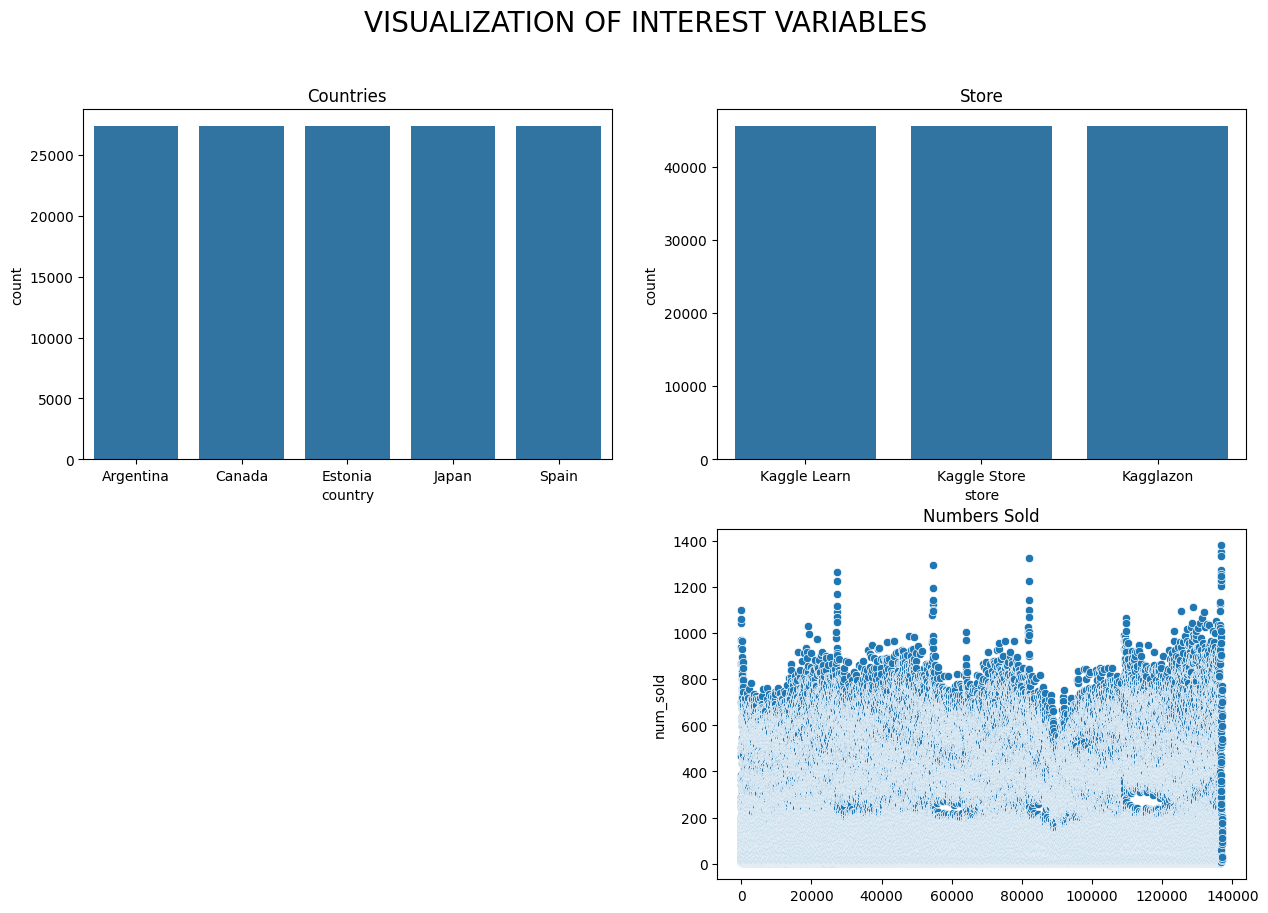

In [3]:
#Generating subplots
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('VISUALIZATION OF INTEREST VARIABLES', fontsize=20)

#Generating visualizations
sns.barplot(df['country'].value_counts(), ax=ax[0,0])
sns.barplot(df['store'].value_counts(), ax=ax[0,1])
sns.scatterplot(df['num_sold'], ax=ax[1,1])

#Disabling unused axis
ax[1,0].axis('off')

#Labeling visualizations
ax[0,0].set_title('Countries')
ax[0,1].set_title('Store')
ax[1,1].set_title('Numbers Sold')
plt.show()

## FEATURE ENGINEERING

In [4]:
# Define the dataframes
dataframes = [df, test_df]

# Define the cyclic features and their corresponding sine and cosine transformations
cyclic_features = ['month', 'day', 'day_of_week', 'week']

# Loop through the dataframes
for dataframe in dataframes:
    #Shortening strings in product column
    dataframe['product'] = dataframe['product'].str.slice(14)
        
    # Convert date column to datetime
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    
    # Extract date-related features from 'date' column
    dataframe['year'] = dataframe['date'].dt.year
    dataframe['quarter'] = dataframe['date'].dt.quarter
    dataframe['month'] = dataframe['date'].dt.month
    dataframe['day_of_week'] = dataframe['date'].dt.dayofweek
    dataframe['is_weekend'] = dataframe['day_of_week'].isin([5, 6]).astype(int)
    dataframe['day'] = dataframe['date'].dt.day
    dataframe['week'] = dataframe['date'].dt.isocalendar().week
    
    # Add sine and cosine transformations for cyclic date features
    for feature in cyclic_features:
        dataframe[f'sin_{feature}'] = np.sin(2 * np.pi * dataframe[feature] /
                                             (13 if feature == 'month' else 7 
                                              if feature == 'day_of_week' else 31 
                                              if feature == 'day' else 52))
        
        dataframe[f'cos_{feature}'] = np.cos(2 * np.pi * dataframe[feature] / 
                                             (13 if feature == 'month' else 7 
                                              if feature == 'day_of_week' else 31 
                                              if feature == 'day' else 52))
    
    #Dropping unnecessary columns
    dataframe.drop(columns=['id', 'date'], axis=1, inplace=True)

In [5]:
#Converting catergorical variables to binary
df = pd.get_dummies(data=df,
                    columns=['country', 'store', 'product'])

test_df = pd.get_dummies(data=test_df,
                         columns=['country', 'store', 'product'])

In [6]:
df.columns

Index(['num_sold', 'year', 'quarter', 'month', 'day_of_week', 'is_weekend',
       'day', 'week', 'sin_month', 'cos_month', 'sin_day', 'cos_day',
       'sin_day_of_week', 'cos_day_of_week', 'sin_week', 'cos_week',
       'country_Argentina', 'country_Canada', 'country_Estonia',
       'country_Japan', 'country_Spain', 'store_Kagglazon',
       'store_Kaggle Learn', 'store_Kaggle Store',
       'product_Improve Your Coding', 'product_Train More LLMs',
       'product_Win Friends and Influence People',
       'product_Win More Kaggle Competitions', 'product_Write Better'],
      dtype='object')

## MODEL PREP

In [7]:
#Defining X and y variables
y = df.num_sold
X = df.drop(columns=['num_sold'], axis=1)

#Generating train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

#Generating dataframe for split
split = pd.DataFrame(data={"Dimensions":[X_train.shape, 
                                         X_test.shape, 
                                         y_train.size, 
                                         y_test.size]},
                    index=["X Train", "X Test", "Y Train" ,"Y Test"])

#Previewing split
split

,Dimensions
X Train,"(102712, 28)"
X Test,"(34238, 28)"
Y Train,102712
Y Test,34238


In [8]:
#Generating empty lists to store results 
Model = []
MAE = []
MSE = []
MPE = []
R2 = []

# Generating function to store and display results
def resultify(name_or_results, test=None, pred=None):
    """
    Processes results if test and pred are provided, 
    or displays results if passed with no additional arguments.
    """
    
    # If called with no test/pred arguments, display the results DataFrame
    if test is None and pred is None:
        return pd.DataFrame(
            data={'MAE': MAE,
                  'MSE': MSE,
                  'MPE': MPE,
                  'R²': R2},
            index=Model
        )
    
    # Ensure all required arguments are provided for result processing
    if not (test is None or pred is None):
        # Generate evaluation scores
        mae_value = mean_absolute_error(pred, test)
        mse_value = mean_squared_error(pred, test)
        mpe_value = mean_absolute_percentage_error(pred, test)
        r2_value = r2_score(pred, test)

        #Appending values to list
        Model.append(name_or_results)
        MAE.append(mae_value)
        MSE.append(mse_value)
        MPE.append(mpe_value)
        R2.append(r2_value)

## INITIALIZING MODELS

In [9]:
#Initializing first base Regressor
rfr = RandomForestRegressor(random_state=42).fit(X_train, y_train)

#Initializing second base Regressor
gbr = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)

#Initializing third base Regressor
xgr = XGBRegressor(objective='reg:squarederror', n_estimators=1000).fit(X_train, y_train)

print("RegressorS READY")

RegressorS READY


## PREDICTIONS

In [10]:
#Generating predictions
rfr_pred = rfr.predict(X_test)
resultify("RANDOM FOREST", y_test, rfr_pred) #Applying resultify

#Generating predictions
gbr_pred = gbr.predict(X_test)
resultify("GRADIENT BOOSTING", y_test, gbr_pred) #Applying resultify

#Generating predictions
xgr_pred = xgr.predict(X_test)
resultify("X GRADIENT BOOSTING", y_test, xgr_pred) #Applying resultify

In [11]:
#Displaying results
resultify('results')

,MAE,MSE,MPE,R²
RANDOM FOREST,8.356004,254.881242,0.052009,0.992415
GRADIENT BOOSTING,18.932657,1028.543518,3.451058,0.966299
X GRADIENT BOOSTING,7.926935,197.354002,0.067435,0.994139


## REGRESSION PLOT

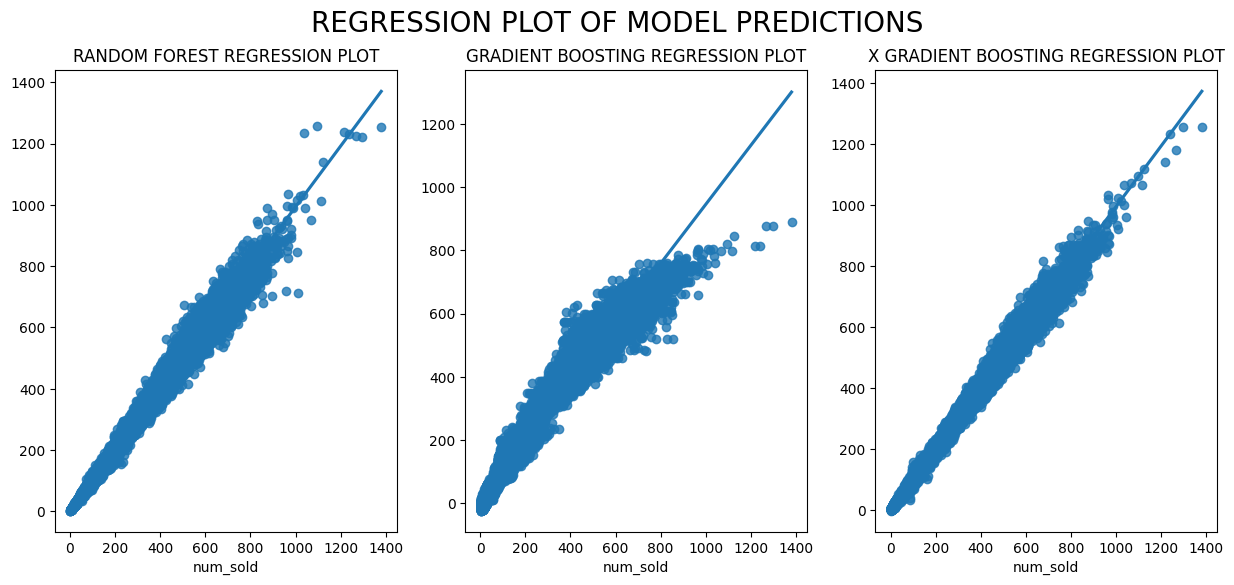

In [12]:
#Generating subplots
fig, ax = plt.subplots(1,3, figsize=(15,6))
plt.suptitle("REGRESSION PLOT OF MODEL PREDICTIONS", fontsize=20)

#Generating Visualizations
sns.regplot(x=y_test, y=rfr_pred, ax=ax[0])
sns.regplot(x=y_test, y=gbr_pred, ax=ax[1])
sns.regplot(x=y_test, y=xgr_pred, ax=ax[2])

#Labelling subplots
ax[0].set_title("RANDOM FOREST REGRESSION PLOT")
ax[1].set_title("GRADIENT BOOSTING REGRESSION PLOT")
ax[2].set_title("X GRADIENT BOOSTING REGRESSION PLOT")
plt.show()

## FEATURE IMPORTANCE

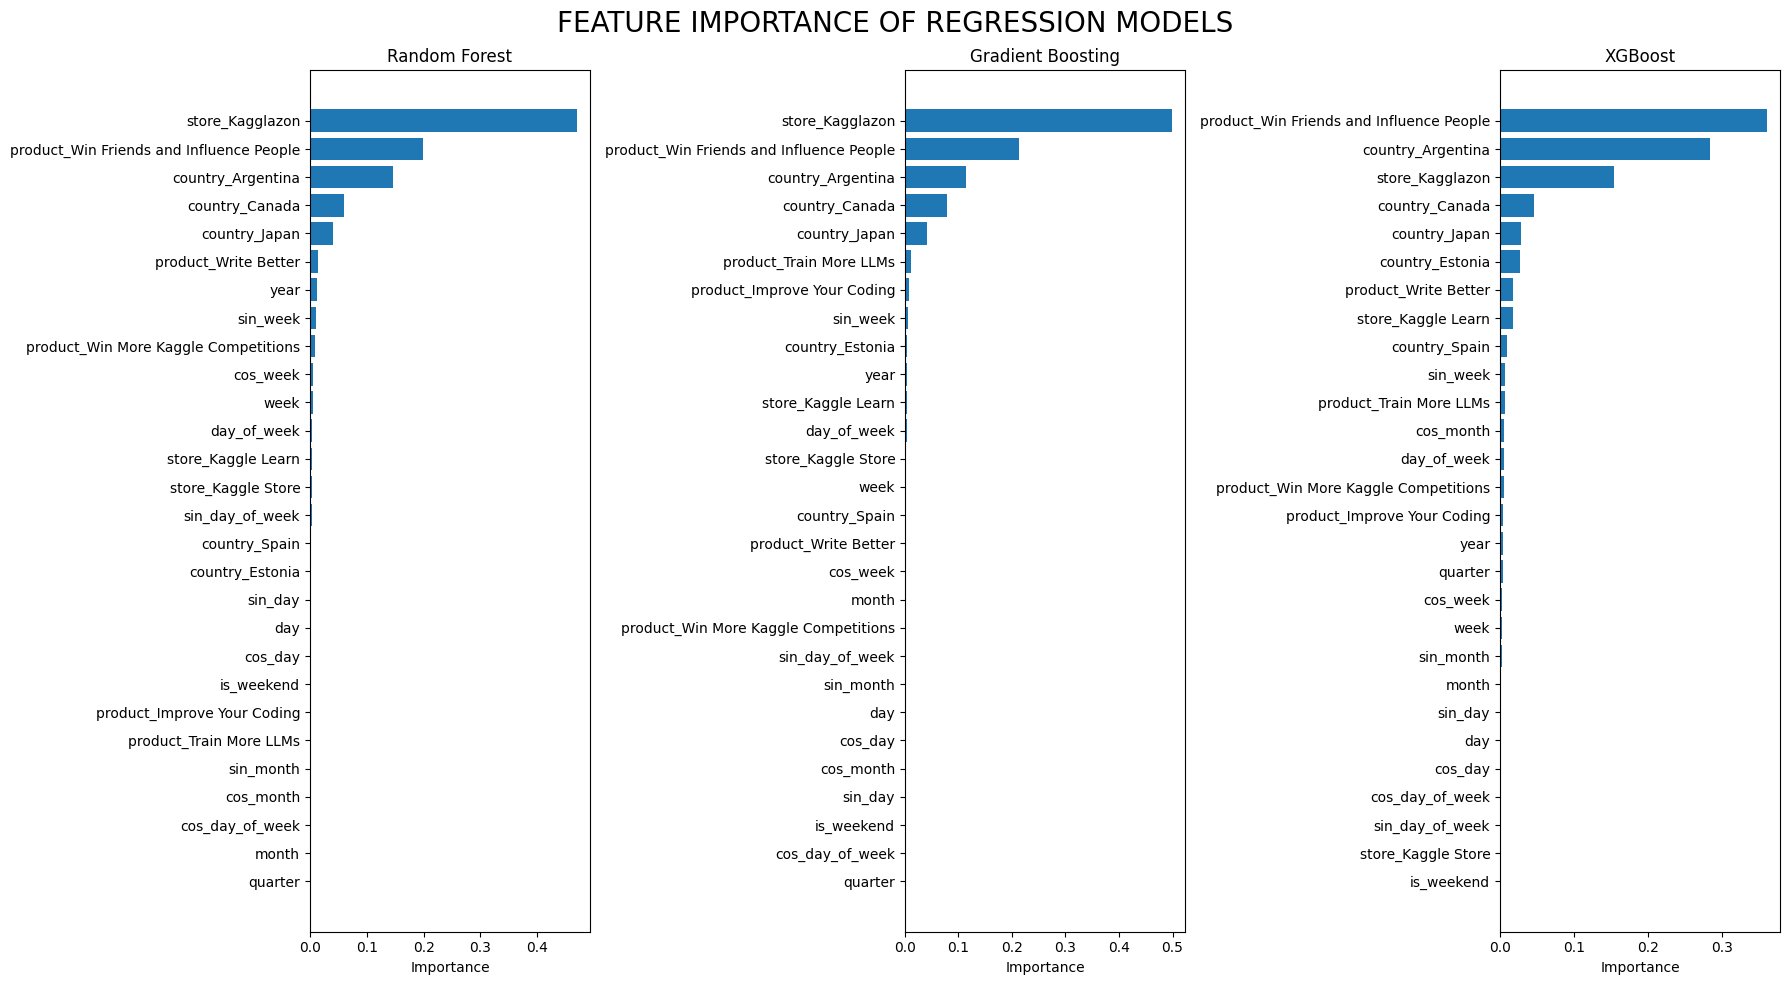

In [13]:
# Get feature importances
rfr_importances = rfr.feature_importances_
gbr_importances = gbr.feature_importances_
xgr_importances = xgr.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in ascending order
rfr_sorted_idx = np.argsort(rfr_importances)
gbr_sorted_idx = np.argsort(gbr_importances)
xgr_sorted_idx = np.argsort(xgr_importances)

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
plt.suptitle("FEATURE IMPORTANCE OF REGRESSION MODELS", fontsize=20)

# Plot feature importances for RandomForestClassifier
ax[0].barh(feature_names[rfr_sorted_idx], rfr_importances[rfr_sorted_idx])
ax[0].set_title("Random Forest")
ax[0].set_xlabel("Importance")

# Plot feature importances for GradientBoostingClassifier
ax[1].barh(feature_names[gbr_sorted_idx], gbr_importances[gbr_sorted_idx])
ax[1].set_title("Gradient Boosting")
ax[1].set_xlabel("Importance")

# Plot feature importances for XGBClassifier
ax[2].barh(feature_names[xgr_sorted_idx], xgr_importances[xgr_sorted_idx])
ax[2].set_title("XGBoost")
ax[2].set_xlabel("Importance")

plt.tight_layout()
plt.show()

## SUBMISSION

In [14]:
#Generating dataframe for testing data
submission_df = pd.DataFrame(data={'id': np.arange(136950, 164325),
                                   'num_sold': xgr.predict(test_df)})

#Generating submission csv
submission_df.to_csv('11.3 Submission.csv', index=False)

#Previewing predictions
submission_df.head(5)

,id,num_sold
0,136950,55.063812
1,136951,48.787777
2,136952,16.960333
3,136953,50.238117
4,136954,39.000916
